In [1]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import models
from sklearn.metrics import classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

import cv2
import mediapipe as mp
import pyautogui

In [9]:
# ====== Настройки ======
print(f'Vesrsion of torch: {torch.__version__}')
data_dir = '../data/split'
batch_size = 128
epochs = 20
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Vesrsion of torch: 2.7.0+cu128
cuda


In [3]:
# ====== Аугментации и трансформации ======
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# ====== Загрузка данных ======
#train_dataset = ImageFolder(os.path.join('../data', 'sample_train'), transform=train_transform)
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
val_dataset   = ImageFolder(os.path.join(data_dir, 'val'), transform=val_test_transform)
test_dataset  = ImageFolder(os.path.join(data_dir, 'test'), transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, num_workers=8)
test_loader  = DataLoader(test_dataset, batch_size=batch_size,num_workers=8)

print(len(train_dataset.classes))
print(train_dataset.classes)

34
['call', 'dislike', 'fist', 'four', 'grabbing', 'grip', 'gun', 'hand_heart', 'hand_heart2', 'holy', 'like', 'little_finger', 'middle_finger', 'mute', 'no_gesture', 'ok', 'one', 'palm', 'peace', 'peace_inverted', 'point', 'rock', 'stop', 'stop_inverted', 'take_picture', 'three', 'three2', 'three3', 'thumb_index', 'thumb_index2', 'timeout', 'two_up', 'two_up_inverted', 'xsign']


In [5]:
# --- Подготовка случайного поднабора из 500 примеров для валидации во время обучения ---
num_val_samples = 500
all_indices = list(range(len(val_dataset)))
# если валидационный набор меньше 500, возьмём весь
selected_indices = random.sample(all_indices, min(num_val_samples, len(all_indices)))
# создаём Subset и новый DataLoader
val_subset = Subset(val_dataset, selected_indices)
val_subset_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=val_loader.num_workers,
    pin_memory=True
)

## Обучаю свою простую CNN

In [26]:
# ====== Своя CNN ======
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),  # (B, 3, 224, 224) -> (B, 32, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(2),                # -> (B, 32, 112, 112)

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                # -> (B, 64, 56, 56)

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                # -> (B, 128, 28, 28)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

model = SimpleCNN(num_classes=len(train_dataset.classes)).to(device)

In [27]:
# ====== Обучение ======
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")

Epoch 1/10: 100%|██████████| 1298/1298 [01:24<00:00, 15.45it/s]


Epoch 1, Loss: 2.1406


Epoch 2/10: 100%|██████████| 1298/1298 [01:22<00:00, 15.74it/s]


Epoch 2, Loss: 2.0117


Epoch 3/10: 100%|██████████| 1298/1298 [01:22<00:00, 15.71it/s]


Epoch 3, Loss: 1.8450


Epoch 4/10: 100%|██████████| 1298/1298 [01:24<00:00, 15.41it/s]


Epoch 4, Loss: 1.6887


Epoch 5/10: 100%|██████████| 1298/1298 [01:22<00:00, 15.64it/s]


Epoch 5, Loss: 1.5480


Epoch 6/10: 100%|██████████| 1298/1298 [01:22<00:00, 15.74it/s]


Epoch 6, Loss: 1.4285


Epoch 7/10: 100%|██████████| 1298/1298 [01:22<00:00, 15.68it/s]


Epoch 7, Loss: 1.3389


Epoch 8/10: 100%|██████████| 1298/1298 [01:22<00:00, 15.73it/s]


Epoch 8, Loss: 1.2594


Epoch 9/10: 100%|██████████| 1298/1298 [01:24<00:00, 15.33it/s]


Epoch 9, Loss: 1.1973


Epoch 10/10: 100%|██████████| 1298/1298 [01:24<00:00, 15.40it/s]

Epoch 10, Loss: 1.1238


In [28]:
# ====== Оценка ======
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu()
        y_pred.extend(preds.tolist())
        y_true.extend(labels.tolist())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

# ====== Сохранение ======
torch.save(model.state_dict(), "custom_gesture_model.pth")


Classification Report:
              precision    recall  f1-score   support

     dislike       0.74      0.76      0.75      4745
        fist       0.55      0.61      0.58      4732
        like       0.57      0.62      0.60      4688
        mute       0.77      0.76      0.77      4853
  no_gesture       0.33      0.48      0.39       326
          ok       0.62      0.44      0.51      4674
         one       0.53      0.65      0.58      4782
        palm       0.67      0.64      0.66      4757
        stop       0.57      0.48      0.52      4691

    accuracy                           0.62     38248
   macro avg       0.60      0.61      0.60     38248
weighted avg       0.63      0.62      0.62     38248



## Обучаю resnet

In [10]:
# ====== Загрузка предобученной ResNet18 и изменение последнего слоя ======
resnet_model = models.resnet18(pretrained=True)

# Для заморозки всех слоёв кроме последнего:
# for param in resnet_model.parameters():
#     param.requires_grad = False

num_classes = len(train_dataset.classes)
resnet_model.fc = nn.Sequential(
    nn.Dropout(p=0.5),  # Dropout перед классификацией
    nn.Linear(resnet_model.fc.in_features, num_classes) 
)


resnet_model = resnet_model.to(device)

In [11]:
num_classes

34

In [12]:
# ====== Настройка обучения ======
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=lr)
train_losses = []
val_losses = []


In [13]:
# ====== Цикл обучения ======
for epoch in range(epochs):
    resnet_model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # --- Валидационная фаза ---
    resnet_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_subset_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet_model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    avg_val_loss = running_val_loss / len(val_subset_loader)
    val_losses.append(avg_val_loss)


    print(f"Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1/20: 100%|██████████| 5941/5941 [22:51<00:00,  4.33it/s]


Train Loss: 0.3826, Val Loss: 0.2189


Epoch 2/20: 100%|██████████| 5941/5941 [22:27<00:00,  4.41it/s]


Train Loss: 0.2030, Val Loss: 0.1631


Epoch 3/20: 100%|██████████| 5941/5941 [22:50<00:00,  4.33it/s]


Train Loss: 0.1597, Val Loss: 0.1417


Epoch 4/20: 100%|██████████| 5941/5941 [22:42<00:00,  4.36it/s]


Train Loss: 0.1349, Val Loss: 0.1690


Epoch 5/20: 100%|██████████| 5941/5941 [23:02<00:00,  4.30it/s]


Train Loss: 0.1187, Val Loss: 0.1104


Epoch 6/20: 100%|██████████| 5941/5941 [23:03<00:00,  4.29it/s]


Train Loss: 0.1070, Val Loss: 0.0986


Epoch 7/20: 100%|██████████| 5941/5941 [22:59<00:00,  4.31it/s]


Train Loss: 0.0981, Val Loss: 0.0703


Epoch 8/20: 100%|██████████| 5941/5941 [23:01<00:00,  4.30it/s]


Train Loss: 0.0896, Val Loss: 0.0873


Epoch 9/20: 100%|██████████| 5941/5941 [23:08<00:00,  4.28it/s]


Train Loss: 0.0834, Val Loss: 0.1247


Epoch 10/20: 100%|██████████| 5941/5941 [22:58<00:00,  4.31it/s]


Train Loss: 0.0789, Val Loss: 0.0796


Epoch 11/20: 100%|██████████| 5941/5941 [22:59<00:00,  4.31it/s]


Train Loss: 0.0738, Val Loss: 0.0777


Epoch 12/20: 100%|██████████| 5941/5941 [23:03<00:00,  4.30it/s]


Train Loss: 0.0704, Val Loss: 0.0650


Epoch 13/20: 100%|██████████| 5941/5941 [23:00<00:00,  4.30it/s]


Train Loss: 0.0668, Val Loss: 0.0650


Epoch 14/20: 100%|██████████| 5941/5941 [23:08<00:00,  4.28it/s]


Train Loss: 0.0631, Val Loss: 0.0887


Epoch 15/20: 100%|██████████| 5941/5941 [23:03<00:00,  4.29it/s]


Train Loss: 0.0610, Val Loss: 0.0755


Epoch 16/20: 100%|██████████| 5941/5941 [23:03<00:00,  4.30it/s]


Train Loss: 0.0572, Val Loss: 0.0514


Epoch 17/20: 100%|██████████| 5941/5941 [23:02<00:00,  4.30it/s]


Train Loss: 0.0561, Val Loss: 0.0677


Epoch 18/20: 100%|██████████| 5941/5941 [23:02<00:00,  4.30it/s]


Train Loss: 0.0532, Val Loss: 0.0409


Epoch 19/20: 100%|██████████| 5941/5941 [22:59<00:00,  4.31it/s]


Train Loss: 0.0512, Val Loss: 0.0749


Epoch 20/20: 100%|██████████| 5941/5941 [23:05<00:00,  4.29it/s]


Train Loss: 0.0494, Val Loss: 0.0496


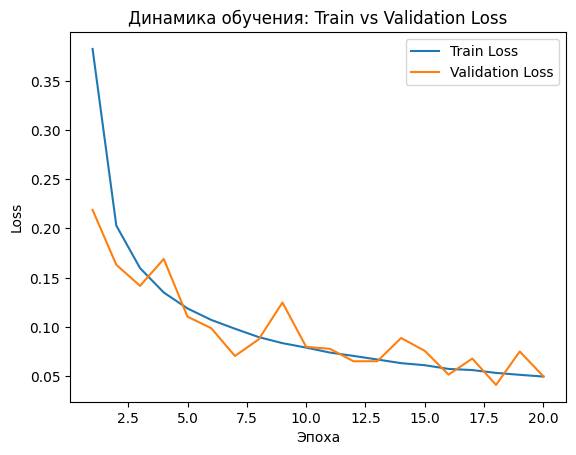

In [16]:
# --- Построение графика ---
plt.figure()
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses,   label='Validation Loss')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('Динамика обучения: Train vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
# ====== Оценка ======
resnet_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)Ы
        outputs = resnet_model(images)
        preds = outputs.argmax(dim=1).cpu()
        y_pred.extend(preds.tolist())
        y_true.extend(labels.tolist())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))


Classification Report:
                 precision    recall  f1-score   support

           call       0.93      0.97      0.95      4209
        dislike       0.97      0.97      0.97      4743
           fist       0.95      0.95      0.95      4731
           four       0.93      0.93      0.93      4715
       grabbing       0.99      0.95      0.97      5452
           grip       0.99      0.97      0.98      5460
            gun       0.98      0.98      0.98      5631
     hand_heart       0.99      0.99      0.99      4436
    hand_heart2       0.99      0.99      0.99      4797
           holy       1.00      0.99      1.00      5910
           like       0.94      0.89      0.92      4686
  little_finger       0.98      0.98      0.98      5445
  middle_finger       0.92      0.98      0.95      5705
           mute       0.95      0.99      0.97      4852
     no_gesture       0.77      0.88      0.82       324
             ok       0.96      0.92      0.94      4672
      

In [17]:
#====== Сохранение ======
torch.save(resnet_model.state_dict(), "trained_res18_full_train_all_gestures.pth")

## Проба прода

In [18]:
# ——— Настройка модели ———
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet18(weights=None)

model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(model.fc.in_features, num_classes)
)

model.load_state_dict(torch.load('trained_res18_full_train_all_gestures.pth'))
model.to(device).eval()

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [19]:
# ——— Настройка MediaPipe ———
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.85,
    min_tracking_confidence=0.85
)
mp_draw = mp.solutions.drawing_utils

In [28]:
# thresholds
TH_X, TH_Y = 40, 40

cap = cv2.VideoCapture('test_video5.mp4')
if not cap.isOpened():
    print("Ошибка: не удалось открыть видеофайл.")
tracking = False
start_pos = None
active_gesture = None

In [ ]:
import collections
import pyautogui
import cv2
import numpy as np
import torch
import time
from collections import deque, Counter

# ——— Настройки ———
N_FRAMES = 20               # Сколько последних кадров учитывать для сглаживания
CONF_THRESHOLD = 0.8        # Порог уверенности модели
TH_X, TH_Y = 20, 20         # Пороги движения по X и Y
gesture_buffer = deque(maxlen=N_FRAMES)

tracking = False
activated = False
active_gesture = None
start_pos = None
last_activation_time = 0
activation_cooldown = 4.0   # Секунда между активациями режима

last_action_time = 0
action_cooldown = 3.0       # Секунда между нажатиями клавиш (like/dislike)

# ——— Цикл обработки кадров ———
while True:
    ret, frame = cap.read()
    if not ret:
        break

    current_time = time.time()

    # 1) Классификация кадра
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(pil)
        probs = torch.softmax(out, dim=1)
        confidence, cls = probs.max(1)
        if confidence.item() < CONF_THRESHOLD:
            gesture = 'no_gesture'
        else:
            gesture = train_dataset.classes[cls.item()]

    gesture_buffer.append(gesture)

    # Majority vote
    if len(gesture_buffer) == N_FRAMES:
        most_common_gesture, count = Counter(gesture_buffer).most_common(1)[0]
    else:
        most_common_gesture = 'no_gesture'

    # 2) Детекция ключевых точек руки
    res = hands.process(img)
    if res.multi_hand_landmarks:
        lm = res.multi_hand_landmarks[0].landmark
        coords = np.array([[int(pt.x * frame.shape[1]), int(pt.y * frame.shape[0])] for pt in lm])

        # Рисуем ключевые точки
        for coord in coords:
            cv2.circle(frame, tuple(coord), 5, (0, 255, 0), -1)

        # Центр руки
        center = coords.mean(axis=0).astype(int)
        cv2.circle(frame, tuple(center), 5, (0, 255, 0), -1)

        # Геометрическая валидация like/dislike
        thumb_tip = coords[4] # конец большого пальца
        index_tip = coords[8] # конец указательного пальца
        # Распознали жест как "like", но конец большого пальца ниже конца указательного
        if most_common_gesture == 'like' and not (thumb_tip[1] < index_tip[1]):
            most_common_gesture = 'no_gesture'
        # Распознали жест как "dislike", но конец большого пальца выше конца указательного
        if most_common_gesture == 'dislike' and not (thumb_tip[1] > index_tip[1]):
            most_common_gesture = 'no_gesture'
    else:
        center = None

    # 3) Логика активации/деактивации режима
    if most_common_gesture == 'timeout' and (current_time - last_activation_time) > activation_cooldown:
        activated = not activated
        print(f'Режим {"активирован" if activated else "деактивирован"}')
        last_activation_time = current_time
        gesture_buffer.clear()
        continue

    # 4) Логика трекинга жестов для управления
    if activated and center is not None and most_common_gesture in ('palm', 'grabbing', 'thumb_index'):
        if not tracking or most_common_gesture != active_gesture:
            # Только при начале нового трекинга
            tracking = True
            active_gesture = most_common_gesture
            start_pos = center.copy()
            last_center = center.copy()
        else:
            dx, dy = center - start_pos
            move_dx, move_dy = center - last_center

            if most_common_gesture in ('palm', 'grabbing'):
                # Перемотка: обновляем стартовую точку после каждого шага
                if abs(dx) > TH_X:
                    if dx > 0:
                        pyautogui.press('right')  # перемотка вперёд
                    else:
                        pyautogui.press('left')   # перемотка назад
                    start_pos = center.copy()

            elif most_common_gesture == 'thumb_index':
                # Громкость: работаем от первой точки, но если жест остановился - перезапускаем
                if abs(dy) > TH_Y:
                    if dy < 0:
                        pyautogui.press('volumeup')
                    else:
                        pyautogui.press('volumedown')
                    
                    # После нажатия НЕ обновляем start_pos!
                
                # Проверка: если рука почти не движется, перезапускаем отсчет
                if abs(move_dy) < 5 and abs(move_dx) < 5:
                    start_pos = center.copy()

            last_center = center.copy()

    else:
        tracking = False

    # 5) Логика управления лайками/дизлайками
    if activated and most_common_gesture in ('like', 'dislike') and (current_time - last_action_time) > action_cooldown:
        if most_common_gesture == 'like':
            pyautogui.press('l')
        elif most_common_gesture == 'dislike':
            pyautogui.press('d')
        last_action_time = current_time
        gesture_buffer.clear()

    # 6) Логика управления действиями типа пауза / следующее видео
    if activated and most_common_gesture in ('stop', 'gun') and (current_time - last_action_time) > action_cooldown:
        if most_common_gesture == 'stop':
            pyautogui.press('space')  # Пауза/возобновление видео (обычно Space)
        elif most_common_gesture == 'gun':
            pyautogui.press('n')  # Следующее видео, например 'n' или 'right', зависит от сайта
        last_action_time = current_time
        gesture_buffer.clear()

    # 7) Отображение
    status_text = f"Gesture: {most_common_gesture} | {'Active' if activated else 'Inactive'}"
    cv2.putText(frame, status_text, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    cv2.imshow("Gestures", frame)

    if cv2.waitKey(1) == ord('q'):
        break

# ——— Завершение работы ———
cap.release()
cv2.destroyAllWindows()


Режим активирован
Режим деактивирован
Режим активирован


In [ ]:
import collections
import pyautogui
import cv2
import numpy as np
import torch
from collections import deque, Counter

# Настройки
N_FRAMES = 15  # сколько последних кадров учитывать для сглаживания
CONF_THRESHOLD = 0.8  # порог уверенности модели
TH_X, TH_Y = 20, 20  # пороги движения
gesture_buffer = deque(maxlen=N_FRAMES)

tracking = False
activated = False
active_gesture = None
start_pos = None

while True:
    ret, frame = cap.read()
    if not ret: break

    # 1) Классификация кадра
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(pil)
        probs = torch.softmax(out, dim=1)
        confidence, cls = probs.max(1)
        if confidence.item() < CONF_THRESHOLD:
            gesture = 'no_gesture'
        else:
            gesture = train_dataset.classes[cls.item()]

    gesture_buffer.append(gesture)

    # Majority vote по последним N_FRAMES
    if len(gesture_buffer) == N_FRAMES:
        most_common_gesture, count = Counter(gesture_buffer).most_common(1)[0]
    else:
        most_common_gesture = 'no_gesture'

    # 2) Детекция ключевых точек руки
    res = hands.process(img)
    if res.multi_hand_landmarks:
        lm = res.multi_hand_landmarks[0].landmark
        coords = np.array([[int(pt.x*frame.shape[1]), int(pt.y*frame.shape[0])] for pt in lm])

        # Рисуем все ключевые точки
        for coord in coords:
            cv2.circle(frame, tuple(coord), 5, (0, 255, 0), -1)

        # Вычисляем и рисуем центр руки
        center = coords.mean(axis=0).astype(int)
        cv2.circle(frame, tuple(center), 5, (0,255,0), -1)

        # Геометрическая валидация Like/Dislike
        thumb_tip = coords[4] # конец большого пальца
        index_tip = coords[8] # конец указательного пальца
        
        # Распознали жест как "like", но конец большого пальца ниже конца указательного
        if most_common_gesture == 'like' and not (thumb_tip[1] < index_tip[1]):
            most_common_gesture = 'no_gesture'
        # Распознали жест как "dislike", но конец большого пальца выше конца указательного
        if most_common_gesture == 'dislike' and not (thumb_tip[1] > index_tip[1]):
            most_common_gesture = 'no_gesture'

    else:
        center = None

    # 3) Логика активации/деактивации
    if most_common_gesture == 'timeout':
        activated = not activated
        print(f'Режим {"активирован" if activated else "деактивирован"}')
        cv2.waitKey(1_000)  # задержка 10 секунд после изменения состояния
        gesture_buffer.clear()
        continue

    # 4) Логика трекинга
    if activated and center is not None and most_common_gesture in ('palm', 'thumb_index'):
        if not tracking or most_common_gesture != active_gesture:
            tracking = True
            active_gesture = most_common_gesture
            start_pos = center.copy()
        else:
            dx, dy = center - start_pos

            if most_common_gesture == 'palm':
                if abs(dx) > TH_X:
                    if dx > 0:
                        pyautogui.press('right')  # перемотка вперёд
                    else:
                        pyautogui.press('left')   # перемотка назад
                    start_pos = center
            elif most_common_gesture == 'thumb_index':
                if abs(dy) > TH_Y:
                    if dy < 0:
                        pyautogui.press('volumeup')
                    else:
                        pyautogui.press('volumedown')
                    start_pos = center
    else:
        tracking = False

    # 5) Управление лайками/дизлайками
    if activated and most_common_gesture in ('like', 'dislike'):
        if most_common_gesture == 'like':
            pyautogui.press('l')  # например, нажимаем "лайк"
        elif most_common_gesture == 'dislike':
            pyautogui.press('d')  # например, нажимаем "дизлайк"
        cv2.waitKey(1_000)  # небольшая задержка, чтобы избежать повторных нажатий
        gesture_buffer.clear()

    # 6) Отображение
    status_text = f"Gesture: {most_common_gesture} | {'Active' if activated else 'Inactive'}"
    cv2.putText(frame, status_text, (10,30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)
    cv2.imshow("Gestures", frame)

    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Режим активирован
Режим деактивирован
Режим активирован
Режим деактивирован
Режим активирован
Режим деактивирован


In [ ]:
from collections import deque, Counter
import time

# Настройки
PREDICTION_WINDOW = 10  # сколько последних кадров учитывать
active_mode = False
last_toggle_time = 0
TOGGLE_DELAY = 2  # задержка между переключениями
gesture_buffer = deque(maxlen=PREDICTION_WINDOW)  # буфер последних N предсказаний

while True:
    ret, frame = cap.read()
    if not ret:
        break

    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(pil)
        cls = out.argmax(1).item()
    gesture = train_dataset.classes[cls]

    gesture_buffer.append(gesture)  # сохраняем предсказание в буфер

    # Считаем наиболее часто встречающийся жест в окне
    if len(gesture_buffer) == PREDICTION_WINDOW:
        most_common_gesture, count = Counter(gesture_buffer).most_common(1)[0]
    else:
        most_common_gesture = gesture  # если буфер ещё не заполнен, работаем как обычно

    res = hands.process(img)
    if res.multi_hand_landmarks:
        lm = res.multi_hand_landmarks[0].landmark
        coords = np.array([[int(pt.x * frame.shape[1]), int(pt.y * frame.shape[0])] for pt in lm])

        for coord in coords:
            cv2.circle(frame, tuple(coord), 5, (0, 255, 0), -1)

        center = coords.mean(axis=0).astype(int)
        cv2.circle(frame, tuple(center), 5, (0, 255, 0), -1)
    else:
        center = None

    # Переключение режима на основе most_common_gesture
    current_time = time.time()
    if most_common_gesture == 'like' and (current_time - last_toggle_time) > TOGGLE_DELAY:
        active_mode = not active_mode
        last_toggle_time = current_time

    # Логика трекинга
    if active_mode and most_common_gesture in ('palm', 'one') and center is not None:
        if not tracking or most_common_gesture != active_gesture:
            tracking = True
            active_gesture = most_common_gesture
            start_pos = center.copy()
        else:
            dx, dy = center - start_pos
            if most_common_gesture == 'palm':
                if abs(dx) > TH_X:
                    if dx > 0:
                        pyautogui.press('right')
                    else:
                        pyautogui.press('left')
                    start_pos = center
            if most_common_gesture == 'one':
                if abs(dy) > TH_Y:
                    if dy < 0:
                        pyautogui.press('up')
                    else:
                        pyautogui.press('down')
                    start_pos = center
    else:
        tracking = False

    # отображение
    mode_text = "ACTIVE" if active_mode else "INACTIVE"
    cv2.putText(frame, f"Mode: {mode_text}", (10, 110),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)

    cv2.putText(frame, most_common_gesture, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    cv2.imshow("Gestures", frame)
    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
import time

active_mode = False
last_toggle_time = 0
TOGGLE_DELAY = 2  # секунды между переключениями

while True:
    ret, frame = cap.read()
    if not ret:
        break

    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(pil)
        cls = out.argmax(1).item()
    gesture = train_dataset.classes[cls]

    res = hands.process(img)
    if res.multi_hand_landmarks:
        lm = res.multi_hand_landmarks[0].landmark
        coords = np.array([[int(pt.x * frame.shape[1]), int(pt.y * frame.shape[0])] for pt in lm])

        for coord in coords:
            cv2.circle(frame, tuple(coord), 5, (0, 255, 0), -1)

        center = coords.mean(axis=0).astype(int)
        cv2.circle(frame, tuple(center), 5, (0, 255, 0), -1)
    else:
        gesture = 'no_gesture'
        center = None

    # Логика переключения активного режима
    current_time = time.time()
    if gesture == 'like' and (current_time - last_toggle_time) > TOGGLE_DELAY:
        active_mode = not active_mode
        last_toggle_time = current_time  # обновляем время последнего переключения

    # Логика трекинга
    if active_mode and gesture in ('palm', 'one') and center is not None:
        if not tracking or gesture != active_gesture:
            tracking = True
            active_gesture = gesture
            start_pos = center.copy()
        else:
            dx, dy = center - start_pos
            if gesture == 'palm':
                if abs(dx) > TH_X:
                    if dx > 0:
                        pyautogui.press('right')
                    else:
                        pyautogui.press('left')
                    start_pos = center
            if gesture == 'one':
                if abs(dy) > TH_Y:
                    if dy < 0:
                        pyautogui.press('up')
                    else:
                        pyautogui.press('down')
                    start_pos = center
    else:
        tracking = False

    # отображение
    mode_text = "ACTIVE" if active_mode else "INACTIVE"
    cv2.putText(frame, f"Mode: {mode_text}", (10, 110),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)

    cv2.putText(frame, gesture, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    cv2.imshow("Gestures", frame)
    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

TODO:
1. Жест, который будет давать программе знак, что пора применять другие жесты или наоборот прекратить их применение
2. Закинуть ненужные жесты в No_gestures
3. Прекратить использовать Ok, так как он путается с пальцем вверх (one)
4. Прекратить использовать fist, так как он путается с one
5. После всего этого переобучить модель